In [1]:
import cupy as cp
import numpy as np
import numba
from numba import njit, prange
import matplotlib.pyplot as plt
import os
import pandas as pd
from pathlib import Path
import cv2
from sklearn . model_selection import train_test_split
from sklearn . preprocessing import LabelEncoder , OneHotEncoder
from sklearn . metrics import confusion_matrix ,classification_report
import seaborn as sns
from sklearn.model_selection import KFold
from cupyx.scipy.signal import correlate2d, convolve2d


from sklearn.preprocessing import StandardScaler



/usr/local/lib/python3.11/dist-packages/cupyx/jit/_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


In [2]:
import numpy as np

# --- Per-channel normalization (recommended for RGB) ---
def normalize_per_channel(X):
    """
    X: (N, 3*32*32) float32 in [0,1] ideally
    Returns X normalized per-channel, plus (mean, std) tensors shaped (1,3,1,1).
    """
    Xc = X.reshape(-1, 3, 32, 32).astype(np.float32)
    mean = Xc.mean(axis=(0, 2, 3), keepdims=True)
    std  = Xc.std(axis=(0, 2, 3), keepdims=True) + 1e-7
    Xn   = ((Xc - mean) / std).reshape(-1, 3*32*32)
    return Xn, mean, std

def apply_norm(X, mean, std):
    Xc = X.reshape(-1, 3, 32, 32).astype(np.float32)
    Xn = ((Xc - mean) / std).reshape(-1, 3*32*32)
    return Xn

In [3]:
def afficher_images(X,y):
    # 1) Récupérer les labels uniques et un indice représentatif par classe
    labels = np.unique(y)
    indices = [np.where(y == lab)[0][0] for lab in labels]
    
    # 2) Configuration de la grille 3 lignes × 11 colonnes
    rows, cols = 3, 11
    fig, axes = plt.subplots(rows, cols,
                             figsize=(cols * 1.2, rows * 2),
                             constrained_layout=True)
    
    # 3) Affichage des images
    for idx, (lab, img_idx) in enumerate(zip(labels, indices)):
        r, c = divmod(idx, cols)
        ax = axes[r, c]
        img = X[img_idx].reshape(32, 32, 3)
        ax.imshow(img)
        ax.set_title(le.classes_[lab], fontsize=6)
        ax.axis('off')
    
    plt.show()

✅ Chargé 25740 images, 33 classes.


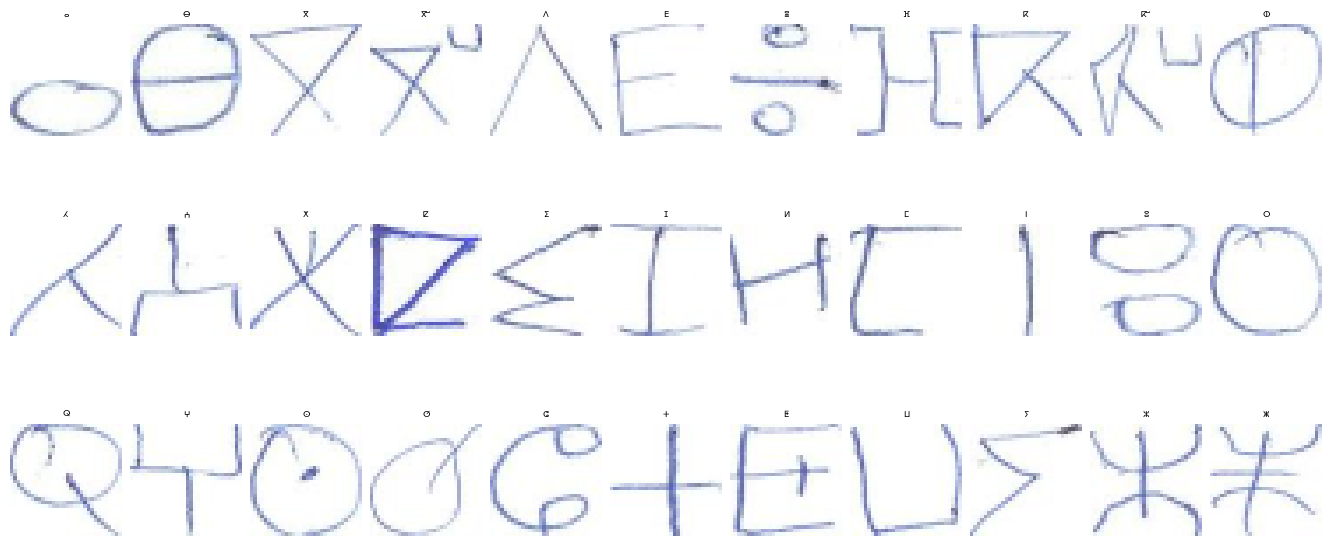

Train=15444, Val=5148, Test=5148


In [4]:
# 1) dossier racine
data_dir = '/kaggle/input/amhcd-dataset/amhcd/AMHCD_64/AMHCD_64'
csv_path = os.path.join(data_dir, 'new-labels-map.csv')

# 2) lire le CSV (rel_path + glyphe UTF-8)
df = pd.read_csv(
    csv_path,
    header=None,
    names=['rel_path', 'glyph'],
    dtype=str,
    encoding='utf-8'
)

# 3) NORMALISATION des chemins : ne garder que label/filename
def make_full_path(rel_p):
    p = Path(rel_p.lstrip('./'))           # supprime un "./" initial
    sub = p.parts[-2:]                     # ne garder que les 2 derniers segments
    return os.path.join(data_dir, *sub)

df['image_path'] = df['rel_path'].apply(make_full_path)

# 4) vérification d’existence
missing = df.loc[~df['image_path'].apply(os.path.exists), 'image_path']
if not missing.empty:
    raise FileNotFoundError("Fichiers introuvables :\n" + "\n".join(missing.tolist()))
print(f"✅ Chargé {len(df)} images, {df['glyph'].nunique()} classes.")

# 5) encoder les glyphes en entiers
le = LabelEncoder()
df['label_enc'] = le.fit_transform(df['glyph'])
num_classes = len(le.classes_)

# Fonction pour charger et p r t r a i t e r une image
def load_and_preprocess_image(image_path , target_size =(32, 32)):
    """
    Load and preprocess an image: convert to grayscale , resize ,
    normalize
    """
    assert os.path.exists(image_path), f"Image not found: {image_path}"
    img = cv2.imread(image_path , cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # BGR -> RGB
    assert img is not None , f"Failed to load image: {image_path}"
    img = cv2.resize(img , target_size)
    img = img.astype(np.float32) / 255.0 # Normalisation
    return img.flatten () # Aplatir pour le r s e a u de neurones
# 7) construire X et y

X = np.stack([load_and_preprocess_image(p) for p in df['image_path']])
y = df['label_enc'].values

afficher_images(X,y)

# 8) split train/val/test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42
)

print(f"Train={len(X_train)}, Val={len(X_val)}, Test={len(X_test)}")

In [5]:
def im2col(x, fH, fW, stride=1, pad=0):
    """
    Convertit un tenseur 4D en colonnes pour accélérer les opérations de convolution.
    """
    N, C, H, W = x.shape

    # Assertions de sécurité
    assert isinstance(x, cp.ndarray), "x doit être un tableau CuPy"
    assert fH > 0 and fW > 0, "Les dimensions du filtre doivent être strictement positives"
    assert stride > 0, "Le stride doit être strictement positif"
    assert pad >= 0, "Le padding ne peut pas être négatif"
    assert H + 2*pad >= fH and W + 2*pad >= fW, "Le filtre dépasse la taille de l'entrée même avec padding"

    H_p, W_p = H + 2*pad, W + 2*pad
    x_p = cp.pad(x, ((0,0),(0,0),(pad,pad),(pad,pad)))

    out_h = (H_p - fH)//stride + 1
    out_w = (W_p - fW)//stride + 1

    assert out_h > 0 and out_w > 0, "Les dimensions de sortie doivent être positives, vérifier les paramètres"

    i0 = cp.repeat(cp.arange(fH), fW)
    i0 = cp.tile(i0, C)
    i1 = stride * cp.repeat(cp.arange(out_h), out_w)
    j0 = cp.tile(cp.arange(fW), fH*C)
    j1 = stride * cp.tile(cp.arange(out_w), out_h)

    i = i0.reshape(-1,1) + i1.reshape(1,-1)
    j = j0.reshape(-1,1) + j1.reshape(1,-1)
    k = cp.repeat(cp.arange(C), fH*fW).reshape(-1,1)

    cols = x_p[:, k, i, j]  # (N, C*fH*fW, out_h*out_w)
    return cols.transpose(1,2,0).reshape(C*fH*fW, -1)


def col2im(cols, x_shape, fH, fW, stride=1, pad=0):
    """
    Reconstruit l'image depuis les colonnes obtenues par im2col.
    """
    N, C, H, W = x_shape

    # Assertions de sécurité
    assert isinstance(cols, cp.ndarray), "cols doit être un tableau CuPy"
    assert len(x_shape) == 4, "x_shape doit être un tuple (N, C, H, W)"
    assert fH > 0 and fW > 0, "Les dimensions du filtre doivent être strictement positives"
    assert stride > 0, "Le stride doit être strictement positif"
    assert pad >= 0, "Le padding ne peut pas être négatif"

    H_p, W_p = H + 2*pad, W + 2*pad
    out_h = (H_p - fH)//stride + 1
    out_w = (W_p - fW)//stride + 1

    expected_cols = C * fH * fW * out_h * out_w
    assert cols.size == expected_cols * N, f"Le nombre d'éléments de cols ({cols.size}) ne correspond pas aux dimensions attendues ({expected_cols * N})"

    cols_reshaped = cols.reshape(C*fH*fW, out_h*out_w, N).transpose(2,0,1)
    x_p = cp.zeros((N, C, H_p, W_p))

    i0 = cp.repeat(cp.arange(fH), fW)
    i0 = cp.tile(i0, C)
    i1 = stride * cp.repeat(cp.arange(out_h), out_w)
    j0 = cp.tile(cp.arange(fW), fH*C)
    j1 = stride * cp.tile(cp.arange(out_w), out_h)

    i = i0.reshape(-1,1) + i1.reshape(1,-1)
    j = j0.reshape(-1,1) + j1.reshape(1,-1)
    k = cp.repeat(cp.arange(C), fH*fW).reshape(-1,1)

    for n in range(N):
        x_p[n, k, i, j] += cols_reshaped[n]

    if pad == 0:
        return x_p
    return x_p[:, :, pad:-pad, pad:-pad]


In [6]:
class LeNet5:
    def __init__(self,
                 num_classes=33,
                 optimizer='adam',
                 lr=0.001,
                 regularisation=0.01,
                 beta1=0.9,
                 beta2=0.999,
                 eps=1e-8):
        assert optimizer.lower() in ['adam', 'sgd'], "Optimizer must be 'adam' or 'sgd'"
        assert num_classes > 0, "num_classes must be positive"
        assert lr > 0, "Learning rate must be positive"
        assert regularisation >= 0, "Regularisation coefficient must be non-negative"
        assert 0 < beta1 < 1 and 0 < beta2 < 1, "Beta values must be between 0 and 1"
        assert eps > 0, "Epsilon must be positive"

        self.optimizer = optimizer.lower()
        self.lr = lr
        self.regularisation = regularisation
        self.beta1, self.beta2, self.eps = beta1, beta2, eps
        self.t = 0

        # Initialisation He
        self.W1 = cp.random.randn( 6, 3, 5, 5)*cp.sqrt(2/25); self.b1 = cp.zeros(6)
        self.W2 = cp.random.randn(16,6,5,5)*cp.sqrt(2/(6*25)); self.b2 = cp.zeros(16)
        self.W3 = cp.random.randn(400,120)*cp.sqrt(2/400); self.b3 = cp.zeros(120)
        self.W4 = cp.random.randn(120,84)*cp.sqrt(2/120);  self.b4 = cp.zeros(84)
        self.W5 = cp.random.randn(84,num_classes)*cp.sqrt(2/84); self.b5 = cp.zeros(num_classes)

        # Moments pour Adam
        z1 = lambda p: cp.zeros_like(p)
        self.mW1, self.vW1 = z1(self.W1), z1(self.W1); self.mb1, self.vb1 = z1(self.b1), z1(self.b1)
        self.mW2, self.vW2 = z1(self.W2), z1(self.W2); self.mb2, self.vb2 = z1(self.b2), z1(self.b2)
        self.mW3, self.vW3 = z1(self.W3), z1(self.W3); self.mb3, self.vb3 = z1(self.b3), z1(self.b3)
        self.mW4, self.vW4 = z1(self.W4), z1(self.W4); self.mb4, self.vb4 = z1(self.b4), z1(self.b4)
        self.mW5, self.vW5 = z1(self.W5), z1(self.W5); self.mb5, self.vb5 = z1(self.b5), z1(self.b5)

    def recuit_simule_initialisation(self, X_val, y_val, iterations=100, T_init=10, alpha=0.95):
        best_loss = np.inf
        best_params = [p.copy() for p in [self.W1, self.b1, self.W2, self.b2, self.W3, self.b3, self.W4, self.b4, self.W5, self.b5]]
        T = T_init
        for i in range(iterations):
            params_before = [p.copy() for p in [self.W1, self.b1, self.W2, self.b2, self.W3, self.b3, self.W4, self.b4, self.W5, self.b5]]
            self.W1 += cp.random.randn(*self.W1.shape) * 0.05
            self.W2 += cp.random.randn(*self.W2.shape) * 0.05
            self.W3 += cp.random.randn(*self.W3.shape) * 0.05
            self.W4 += cp.random.randn(*self.W4.shape) * 0.05
            self.W5 += cp.random.randn(*self.W5.shape) * 0.05
            probs, _ = self.forward(cp.array(X_val).reshape(-1, 3, 32, 32))
            loss = float(-cp.log(probs[cp.arange(len(y_val)), y_val]).mean())
            delta = loss - best_loss
            if delta < 0 or np.random.rand() < np.exp(-delta / T):
                if loss < best_loss:
                    best_loss = loss
                    best_params = [p.copy() for p in [self.W1, self.b1, self.W2, self.b2, self.W3, self.b3, self.W4, self.b4, self.W5, self.b5]]
            else:
                self.W1, self.b1, self.W2, self.b2, self.W3, self.b3, self.W4, self.b4, self.W5, self.b5 = params_before
            T *= alpha
            if i % 10 == 0:
                print(f"Itération {i}, Loss actuelle : {loss:.4f}, Meilleure Loss : {best_loss:.4f}")
        self.W1, self.b1, self.W2, self.b2, self.W3, self.b3, self.W4, self.b4, self.W5, self.b5 = best_params

    def _sgd_update(self, p, grad):
        assert p.shape == grad.shape, "Shape mismatch in SGD update"
        p[:] -= self.lr * (grad + self.regularisation * p)

    def _adam_update(self, p, grad, m, v):
        assert p.shape == grad.shape == m.shape == v.shape, "Shape mismatch in Adam update"
        grad = grad + self.regularisation * p
        self.t += 1
        m[:] = self.beta1*m + (1-self.beta1)*grad
        v[:] = self.beta2*v + (1-self.beta2)*(grad*grad)
        m_hat = m/(1-self.beta1**self.t)
        v_hat = v/(1-self.beta2**self.t)
        p[:] -= self.lr * m_hat/(cp.sqrt(v_hat)+self.eps)

    def _update(self, p, grad, m=None, v=None):
        if self.optimizer=='adam':
            assert m is not None and v is not None, "Adam optimizer requires m and v"
            self._adam_update(p, grad, m, v)
        else:
            self._sgd_update(p, grad)

    def forward(self, X):
        # assert X.ndim == 4 and X.shape[1:] == (3, 32, 32), "Input X must be (N,1,32,32)"
        N = X.shape[0]
        cols1 = im2col(X,5,5)
        o1 = self.W1.reshape(6,-1)@cols1 + self.b1.reshape(-1,1)
        o1 = o1.reshape(6,28,28,N).transpose(3,0,1,2)
        o1 = cp.maximum(o1,0)
        o1p = o1.reshape(N,6,14,2,14,2).mean(axis=(3,5))
        cols2 = im2col(o1p,5,5)
        o2 = self.W2.reshape(16,-1)@cols2 + self.b2.reshape(-1,1)
        o2 = o2.reshape(16,10,10,N).transpose(3,0,1,2)
        o2 = cp.maximum(o2,0)
        o2p= o2.reshape(N,16,5,2,5,2).mean(axis=(3,5))
        flat= o2p.reshape(N,-1)
        f3  = cp.maximum(flat@self.W3+self.b3,0)
        f4  = cp.maximum(f3  @self.W4+self.b4,0)
        logits = f4@self.W5+self.b5
        ex = cp.exp(logits-cp.max(logits,1,keepdims=True))
        probs = ex/ex.sum(1,keepdims=True)
        assert probs.shape == (N,self.W5.shape[1]), "Output probabilities have incorrect shape"
        cache=(X,cols1,o1,o1p,cols2,o2,o2p,flat,f3,f4,probs)
        return probs,cache

    def backward(self, cache, y):
        X,cols1,o1,o1p,cols2,o2,o2p,flat,f3,f4,probs=cache
        N= X.shape[0]
        assert y.shape[0] == N, "Mismatch between batch size and labels"
        dlog=probs.copy(); dlog[cp.arange(N),y]-=1; dlog/=N
        dW5=f4.T@dlog; db5=dlog.sum(0)
        df4=(dlog@self.W5.T)*(f4>0)
        dW4=f3.T@df4; db4=df4.sum(0)
        df3=(df4@self.W4.T)*(f3>0)
        dW3=flat.T@df3; db3=df3.sum(0)
        dflat=df3@self.W3.T
        dS4=cp.kron(dflat.reshape(o2p.shape),cp.ones((1,1,2,2)))/4
        dout2=dS4*(o2>0)
        dout2_mat=dout2.transpose(1,2,3,0).reshape(16,-1)
        dW2=dout2_mat@cols2.T; db2=dout2_mat.sum(1)
        dcols2=(self.W2.reshape(16,-1).T@dout2_mat)
        dS2p=col2im(dcols2,(N,6,14,14),5,5)
        dS2=cp.kron(dS2p.reshape(o1p.shape),cp.ones((1,1,2,2)))/4
        dout1=dS2*(o1>0)
        dout1_mat=dout1.transpose(1,2,3,0).reshape(6,-1)
        dW1=dout1_mat@cols1.T; db1=dout1_mat.sum(1)
        self._update(self.W5,dW5,self.mW5,self.vW5); self._update(self.b5,db5,self.mb5,self.vb5)
        self._update(self.W4,dW4,self.mW4,self.vW4); self._update(self.b4,db4,self.mb4,self.vb4)
        self._update(self.W3,dW3,self.mW3,self.vW3); self._update(self.b3,db3,self.mb3,self.vb3)
        self._update(self.W2,dW2.reshape(self.W2.shape),self.mW2,self.vW2); self._update(self.b2,db2,self.mb2,self.vb2)
        self._update(self.W1,dW1.reshape(self.W1.shape),self.mW1,self.vW1); self._update(self.b1,db1,self.mb1,self.vb1)

    def compute_accuracy(self,y_true,y_pred):
        assert y_true.ndim in [1,2] and y_pred.ndim in [1,2], "Invalid label dimensions"
        if y_pred.ndim==2: preds = np.argmax(y_pred,axis=1)
        else: preds = y_pred
        if y_true.ndim==2: true = np.argmax(y_true,axis=1)
        else: true = y_true
        assert preds.shape==true.shape, "Predictions and labels shape mismatch"
        return np.mean(preds==true)

    def train(self,X,y,Xv,yv,epochs=10,batch_size=64):
        # assert X.shape[1:] == (32,32), "X must be (N,32,32)"
        # assert Xv.shape[1:] == (32,32), "Xv must be (Nv,32,32)"
        Xg=cp.array(X).reshape(-1, 3, 32, 32); yg=cp.array(y)
        Xvg=cp.array(Xv).reshape(-1, 3, 32, 32); yvg=cp.array(yv)
        tr_ls,val_ls,tr_acc,val_acc=[],[],[],[]
        sub=min(batch_size,Xg.shape[0]); idx0=cp.arange(sub)
        for ep in range(epochs):
            perm=cp.random.permutation(Xg.shape[0])
            for i in range(0,Xg.shape[0],batch_size):
                idx=perm[i:i+batch_size]
                probs,cache=self.forward(Xg[idx]); self.backward(cache,yg[idx])
            pr, _ = self.forward(Xg[idx0])
            tr_ls.append(float(-cp.log(pr[cp.arange(sub),yg[idx0]]).mean()))
            tr_acc.append(self.compute_accuracy(cp.asnumpy(yg[idx0]), cp.asnumpy(cp.argmax(pr,axis=1))))
            pr_v,_=self.forward(Xvg)
            val_ls.append(float(-cp.log(pr_v[cp.arange(pr_v.shape[0]),yvg]).mean()))
            val_acc.append(self.compute_accuracy(cp.asnumpy(yvg), cp.asnumpy(cp.argmax(pr_v,axis=1))))
            if ep % 10 == 0:
                print(f"Epoch {ep}, Train Loss: {tr_ls[-1] :.4f}, Val Loss: {val_ls[-1] :.4f}, "f"Train Acc: {tr_acc[-1] :.4f}, Val Acc:{val_acc[-1] :.4f}")
        return tr_ls,val_ls,tr_acc,val_acc

    def predict(self, X):
        # assert X.shape[1:] == (32,32), "X must be (N,32,32)"
        Xg = cp.array(X).reshape(-1, 3, 32, 32)
        probs, _ = self.forward(Xg)
        preds = cp.argmax(probs, axis=1)
        return cp.asnumpy(preds)

Epoch 0, Train Loss: 3.4943, Val Loss: 3.4770, Train Acc: 0.0508, Val Acc:0.0536
Epoch 10, Train Loss: 1.4874, Val Loss: 1.6510, Train Acc: 0.5508, Val Acc:0.5159
Epoch 20, Train Loss: 0.8204, Val Loss: 0.9589, Train Acc: 0.7383, Val Acc:0.7230
Epoch 30, Train Loss: 0.5282, Val Loss: 0.6768, Train Acc: 0.8320, Val Acc:0.8054
Epoch 40, Train Loss: 0.4072, Val Loss: 0.5286, Train Acc: 0.8711, Val Acc:0.8485
Epoch 50, Train Loss: 0.4173, Val Loss: 0.5330, Train Acc: 0.8906, Val Acc:0.8425
Epoch 60, Train Loss: 0.3127, Val Loss: 0.4338, Train Acc: 0.9219, Val Acc:0.8747
Epoch 70, Train Loss: 0.2897, Val Loss: 0.4017, Train Acc: 0.9180, Val Acc:0.8906
Epoch 80, Train Loss: 0.2840, Val Loss: 0.3970, Train Acc: 0.9180, Val Acc:0.8902
Epoch 90, Train Loss: 0.2783, Val Loss: 0.4008, Train Acc: 0.9219, Val Acc:0.8856

=== Classification Report (Test) ===
              precision    recall  f1-score   support

           ⴰ       0.99      1.00      1.00       156
           ⴱ       0.98      0.94 

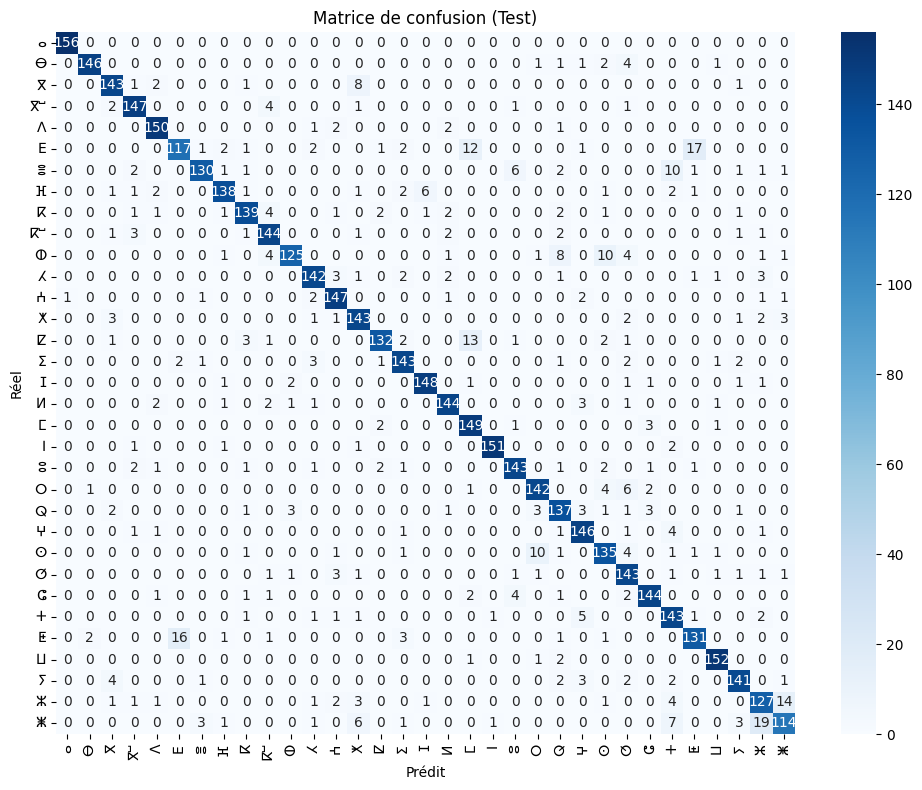

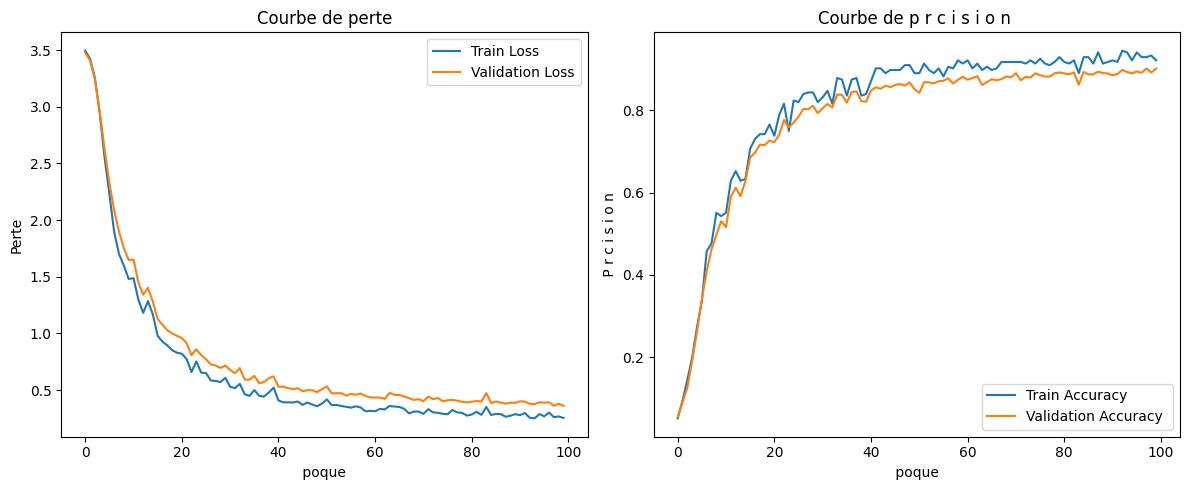

In [7]:
# 10) entraîner le modèle
# Avant entraînement

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val   = scaler.transform(X_val)
X_test  = scaler.transform(X_test)

X_train_reshaped = X_train   # (N, 3*32*32)
X_val_reshaped   = X_val
X_test_reshaped  = X_test
# Les labels : si tu utilises l'encodage simple (pas one-hot)
y_train_labels = y_train
y_val_labels   = y_val
y_test_labels  = y_test


model = LeNet5(num_classes=33,optimizer='sgd',lr=0.01,regularisation=0.01
)

# Entraînement avec labels (pas one-hot)
train_losses, val_losses,train_acc,val_acc = model.train(
    X_train_reshaped, y_train_labels,
    X_val_reshaped, y_val_labels,
    epochs=100,
    batch_size=256
)


# 11) évaluer sur test
y_pred = model.predict(X_test_reshaped)
print("\n=== Classification Report (Test) ===")
print(classification_report(y_test, y_pred, target_names=le.classes_))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Matrice de confusion (Test)')
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Courbes de perte et d’accuracy
fig , (ax1 , ax2) = plt.subplots(1, 2, figsize =(12, 5))

# Courbe de perte
ax1.plot(train_losses , label='Train Loss')
ax1.plot(val_losses , label='Validation Loss')
ax1.set_title('Courbe de perte')
ax1.set_xlabel(' poque ')
ax1.set_ylabel('Perte')
ax1.legend ()

# Courbe d’accuracy
ax2.plot(train_acc , label='Train Accuracy ')
ax2.plot(val_acc , label='Validation Accuracy ')
ax2.set_title('Courbe de p r c i s i o n ')
ax2.set_xlabel(' poque ')
ax2.set_ylabel(' P r c i s i o n ')
ax2.legend ()

plt.tight_layout ()
fig.savefig('loss_accuracy_plot.png')
plt.show()




Epoch 0, Train Loss: 0.8981, Val Loss: 0.9960, Train Acc: 0.7344, Val Acc:0.7119
Epoch 10, Train Loss: 0.5875, Val Loss: 0.5535, Train Acc: 0.8281, Val Acc:0.8331
Epoch 20, Train Loss: 0.3243, Val Loss: 0.4361, Train Acc: 0.8984, Val Acc:0.8667
Epoch 30, Train Loss: 0.3091, Val Loss: 0.5078, Train Acc: 0.8984, Val Acc:0.8450
Epoch 40, Train Loss: 0.3609, Val Loss: 0.4919, Train Acc: 0.8828, Val Acc:0.8533
Epoch 50, Train Loss: 0.4480, Val Loss: 0.4324, Train Acc: 0.8750, Val Acc:0.8770
Epoch 60, Train Loss: 0.4114, Val Loss: 0.4440, Train Acc: 0.8594, Val Acc:0.8733
Epoch 70, Train Loss: 0.3681, Val Loss: 0.4140, Train Acc: 0.9141, Val Acc:0.8809
Epoch 80, Train Loss: 0.3853, Val Loss: 0.4112, Train Acc: 0.8594, Val Acc:0.8796
Epoch 90, Train Loss: 0.3175, Val Loss: 0.4086, Train Acc: 0.8828, Val Acc:0.8798

=== Classification Report (Test) ===
              precision    recall  f1-score   support

           ⴰ       0.99      0.99      0.99       156
           ⴱ       0.90      0.96 

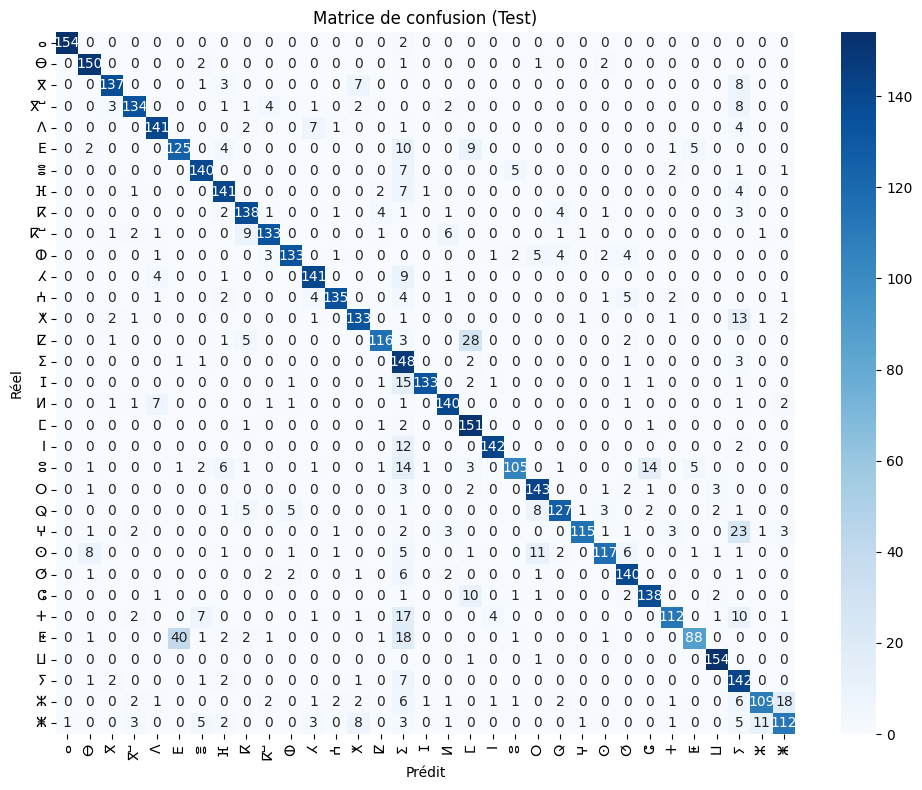

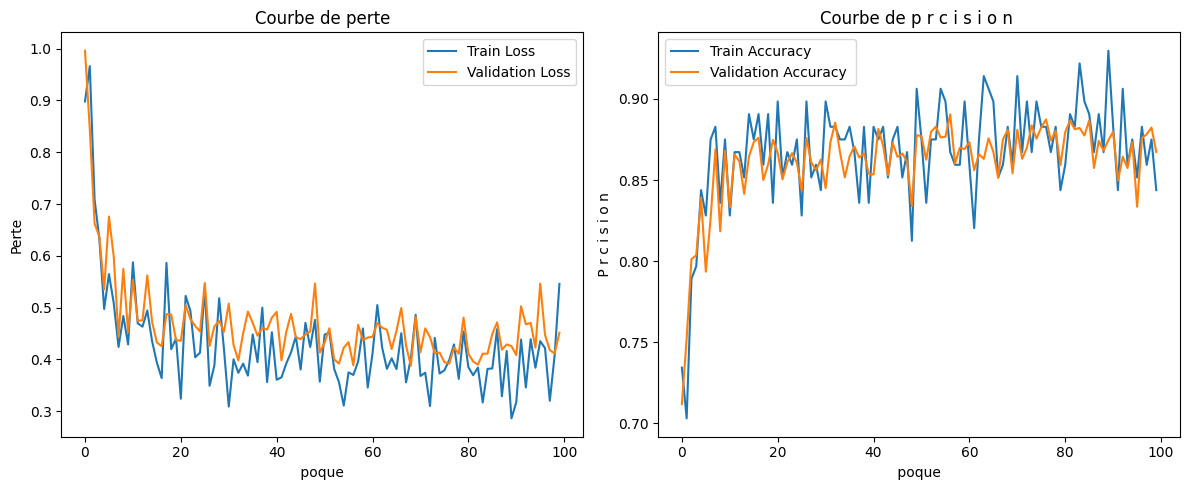

In [8]:
# 10) entraîner le modèle
# Avant entraînement

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val   = scaler.transform(X_val)
X_test  = scaler.transform(X_test)

X_train_reshaped = X_train   # (N, 3*32*32)
X_val_reshaped   = X_val
X_test_reshaped  = X_test

# Les labels : si tu utilises l'encodage simple (pas one-hot)
y_train_labels = y_train
y_val_labels   = y_val
y_test_labels  = y_test


model = LeNet5(num_classes=33,optimizer='adam',lr=0.01,regularisation=0.01
)

# Entraînement avec labels (pas one-hot)
train_losses, val_losses,train_acc,val_acc = model.train(
    X_train_reshaped, y_train_labels,
    X_val_reshaped, y_val_labels,
    epochs=100,
    batch_size=128
)


# 11) évaluer sur test
y_pred = model.predict(X_test_reshaped)
print("\n=== Classification Report (Test) ===")
print(classification_report(y_test, y_pred, target_names=le.classes_))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Matrice de confusion (Test)')
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Courbes de perte et d’accuracy
fig , (ax1 , ax2) = plt.subplots(1, 2, figsize =(12, 5))

# Courbe de perte
ax1.plot(train_losses , label='Train Loss')
ax1.plot(val_losses , label='Validation Loss')
ax1.set_title('Courbe de perte')
ax1.set_xlabel(' poque ')
ax1.set_ylabel('Perte')
ax1.legend ()

# Courbe d’accuracy
ax2.plot(train_acc , label='Train Accuracy ')
ax2.plot(val_acc , label='Validation Accuracy ')
ax2.set_title('Courbe de p r c i s i o n ')
ax2.set_xlabel(' poque ')
ax2.set_ylabel(' P r c i s i o n ')
ax2.legend ()

plt.tight_layout ()
fig.savefig('loss_accuracy_plot.png')
plt.show()




Testing λ=0.001, lr=0.001, batch_size=128 ...
Epoch 0, Train Loss: 3.6279, Val Loss: 3.5918, Train Acc: 0.0547, Val Acc:0.0527
Epoch 10, Train Loss: 2.9527, Val Loss: 3.0130, Train Acc: 0.1562, Val Acc:0.1682
Epoch 20, Train Loss: 2.1487, Val Loss: 2.2838, Train Acc: 0.4141, Val Acc:0.3634
Epoch 30, Train Loss: 1.6669, Val Loss: 1.8121, Train Acc: 0.5547, Val Acc:0.4853
Epoch 40, Train Loss: 1.3149, Val Loss: 1.4881, Train Acc: 0.6484, Val Acc:0.5761
Epoch 50, Train Loss: 1.0938, Val Loss: 1.2685, Train Acc: 0.6953, Val Acc:0.6468
Epoch 60, Train Loss: 0.9355, Val Loss: 1.1184, Train Acc: 0.7500, Val Acc:0.6902
Epoch 70, Train Loss: 0.8113, Val Loss: 1.0031, Train Acc: 0.7656, Val Acc:0.7259
Epoch 80, Train Loss: 0.7265, Val Loss: 0.9210, Train Acc: 0.8047, Val Acc:0.7492
Epoch 90, Train Loss: 0.6567, Val Loss: 0.8532, Train Acc: 0.8047, Val Acc:0.7698
Epoch 0, Train Loss: 3.6063, Val Loss: 3.5187, Train Acc: 0.0156, Val Acc:0.0476
Epoch 10, Train Loss: 2.7764, Val Loss: 2.7818, Train 

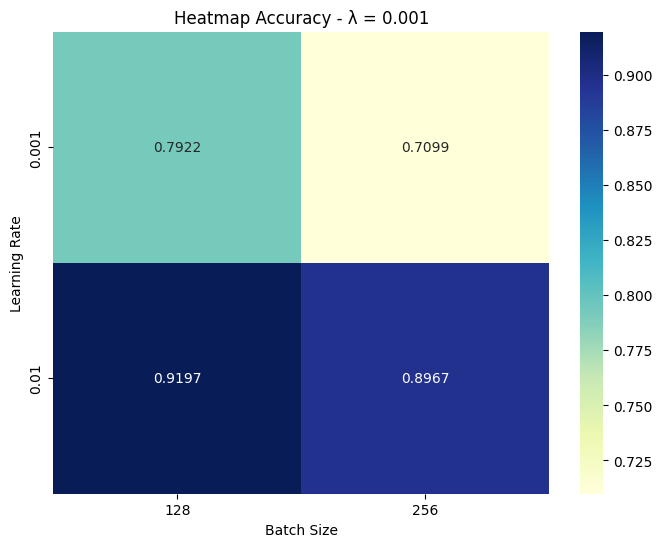

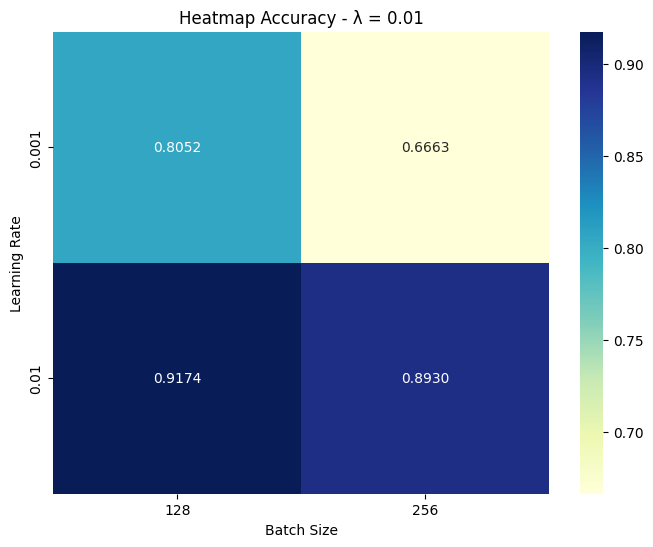

In [9]:
# ----- Définir les hyperparamètres à tester pour model avec optimizer SGD-----
learning_rates = [0.001, 0.01]
batch_sizes    = [128, 256]
lamda_value    = [0.001, 0.01]
n_splits       = 5

# Préparer un tableau 3D : (lr, bs, lamda)
mean_val_accuracy = np.zeros((len(learning_rates), len(batch_sizes), len(lamda_value)))


# ----- Standardisation -----
scaler = StandardScaler()
X_temp = scaler.fit_transform(X_temp)


# ----- Recherche par Cross-Validation -----
for k, lm in enumerate(lamda_value):
    for i, lr in enumerate(learning_rates):
        for j, bs in enumerate(batch_sizes):
            
            print(f"Testing λ={lm}, lr={lr}, batch_size={bs} ...")
            kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
            fold_accuracies = []
    
            for train_index, val_index in kf.split(X_temp):
                
                X_train_fold = X_temp[train_index]
                X_val_fold   = X_temp[val_index]
                y_train_fold = y_temp[train_index]
                y_val_fold   = y_temp[val_index]
                
                # Initialiser le modèle
                model = LeNet5(num_classes=33,optimizer='sgd',lr=lr,regularisation=lm)
    
                # Entraînement
                _, val_losses, _, val_accs = model.train(
                    X_train_fold, y_train_fold,
                    X_val_fold,   y_val_fold,
                    epochs=100, batch_size=bs
                )
                
                fold_accuracies.append(val_accs[-1])
            
            mean_val_accuracy[i, j, k] = np.mean(fold_accuracies)
            print(f"→ Moyenne CV accuracy λ={lm}, lr={lr}, bs={bs} : {mean_val_accuracy[i, j, k]:.4f}")

# ----- Identifier la meilleure combinaison -----
best_idx = np.unravel_index(np.argmax(mean_val_accuracy), mean_val_accuracy.shape)
best_lr  = learning_rates[best_idx[0]]
best_bs  = batch_sizes[best_idx[1]]
best_lm  = lamda_value[best_idx[2]]
best_acc = mean_val_accuracy[best_idx]

print(f"\nMeilleure combinaison SGD : λ={best_lm}, lr={best_lr}, bs={best_bs} avec CV accuracy={best_acc:.4f}")

# ----- Heatmaps séparées pour chaque λ -----
for k, lm in enumerate(lamda_value):
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        mean_val_accuracy[:, :, k],
        annot=True, fmt=".4f",
        xticklabels=batch_sizes,
        yticklabels=learning_rates,
        cmap="YlGnBu"
    )
    plt.title(f"Heatmap Accuracy - λ = {lm}")
    plt.xlabel("Batch Size")
    plt.ylabel("Learning Rate")
    plt.savefig(f"cv_accuracy_heatmap_lambda_{lm}.png")
    plt.show()

Epoch 0, Train Loss: 3.3140, Val Loss: 3.3449, Train Acc: 0.1016, Val Acc:0.1129
Epoch 10, Train Loss: 0.5803, Val Loss: 0.7306, Train Acc: 0.8359, Val Acc:0.7892
Epoch 20, Train Loss: 0.3067, Val Loss: 0.5095, Train Acc: 0.9141, Val Acc:0.8559
Epoch 30, Train Loss: 0.2308, Val Loss: 0.3955, Train Acc: 0.9297, Val Acc:0.8819
Epoch 40, Train Loss: 0.1736, Val Loss: 0.3514, Train Acc: 0.9453, Val Acc:0.8986
Epoch 50, Train Loss: 0.1238, Val Loss: 0.3170, Train Acc: 0.9531, Val Acc:0.9097
Epoch 60, Train Loss: 0.1030, Val Loss: 0.3090, Train Acc: 0.9688, Val Acc:0.9099
Epoch 70, Train Loss: 0.0766, Val Loss: 0.2864, Train Acc: 0.9766, Val Acc:0.9163
Epoch 80, Train Loss: 0.0737, Val Loss: 0.2902, Train Acc: 0.9766, Val Acc:0.9163
Epoch 90, Train Loss: 0.0515, Val Loss: 0.3072, Train Acc: 0.9922, Val Acc:0.9141

Rapport de classification (Test set) avec la meilleure combinaison :
              precision    recall  f1-score   support

           ⴰ       0.99      1.00      1.00       156
  

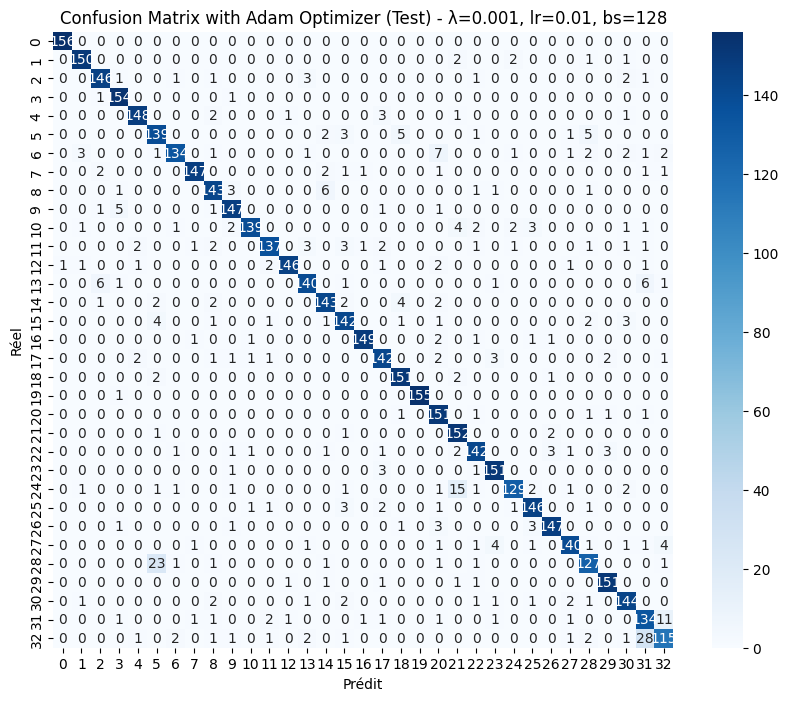

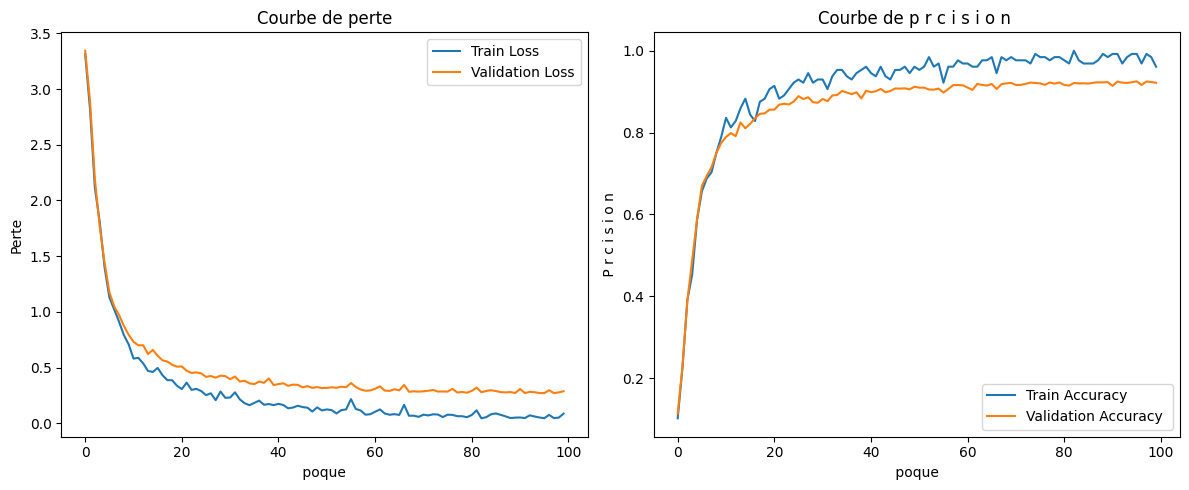

In [10]:
# Avant entraînement
X_train_reshaped = X_train   # (N, 3*32*32)
X_val_reshaped   = X_val
X_test_reshaped  = X_test

# Les labels : si tu utilises l'encodage simple (pas one-hot)
y_train_labels = y_train
y_val_labels   = y_val
y_test_labels  = y_test


# ----- Réentraînement final avec les meilleurs hyperparamètres -----
model = LeNet5(num_classes=33,optimizer='sgd',lr=best_lr,regularisation=best_lm)


train_losses, val_losses,train_acc,val_acc = model.train(X_train_reshaped, y_train_labels,
    X_val_reshaped, y_val_labels,
    epochs=100,batch_size=best_bs
)

# ----- Évaluation finale -----
y_test_pred = model.predict(X_test_reshaped)

print("\nRapport de classification (Test set) avec la meilleure combinaison :")
print(classification_report(y_test, y_test_pred, target_names=le.classes_))

cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f"Confusion Matrix with Adam Optimizer (Test) - λ={best_lm}, lr={best_lr}, bs={best_bs}")
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.savefig("confusion_matrix_best.png")
plt.show()

# Courbes de perte et d’accuracy
fig , (ax1 , ax2) = plt.subplots(1, 2, figsize =(12, 5))

# Courbe de perte
ax1.plot(train_losses , label='Train Loss')
ax1.plot(val_losses , label='Validation Loss')
ax1.set_title('Courbe de perte')
ax1.set_xlabel(' poque ')
ax1.set_ylabel('Perte')
ax1.legend ()

# Courbe d’accuracy
ax2.plot(train_acc , label='Train Accuracy ')
ax2.plot(val_acc , label='Validation Accuracy ')
ax2.set_title('Courbe de p r c i s i o n ')
ax2.set_xlabel(' poque ')
ax2.set_ylabel(' P r c i s i o n ')
ax2.legend ()

plt.tight_layout ()
fig.savefig('loss_accuracy_plot.png')
plt.show()


Testing λ=0.001, lr=0.001, batch_size=128 ...
Epoch 0, Train Loss: 0.6569, Val Loss: 0.7187, Train Acc: 0.8203, Val Acc:0.7922
Epoch 10, Train Loss: 0.0624, Val Loss: 0.2555, Train Acc: 0.9766, Val Acc:0.9267
Epoch 20, Train Loss: 0.0471, Val Loss: 0.2202, Train Acc: 1.0000, Val Acc:0.9427
Epoch 30, Train Loss: 0.0274, Val Loss: 0.2352, Train Acc: 1.0000, Val Acc:0.9405
Epoch 40, Train Loss: 0.0291, Val Loss: 0.2285, Train Acc: 0.9922, Val Acc:0.9388
Epoch 0, Train Loss: 0.8403, Val Loss: 0.7610, Train Acc: 0.7656, Val Acc:0.7817
Epoch 10, Train Loss: 0.0407, Val Loss: 0.2571, Train Acc: 1.0000, Val Acc:0.9257
Epoch 20, Train Loss: 0.0217, Val Loss: 0.2630, Train Acc: 1.0000, Val Acc:0.9264
Epoch 30, Train Loss: 0.0296, Val Loss: 0.2655, Train Acc: 0.9922, Val Acc:0.9243
Epoch 40, Train Loss: 0.0182, Val Loss: 0.2275, Train Acc: 1.0000, Val Acc:0.9403
Epoch 0, Train Loss: 1.2051, Val Loss: 1.0432, Train Acc: 0.5938, Val Acc:0.6819
Epoch 10, Train Loss: 0.0776, Val Loss: 0.2740, Train A

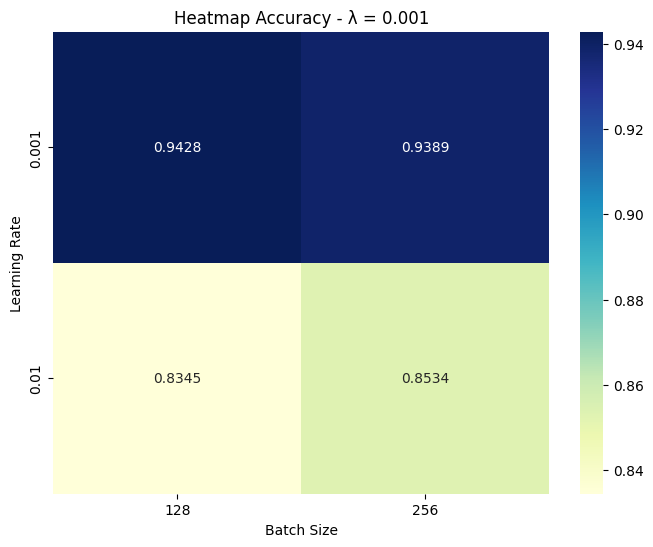

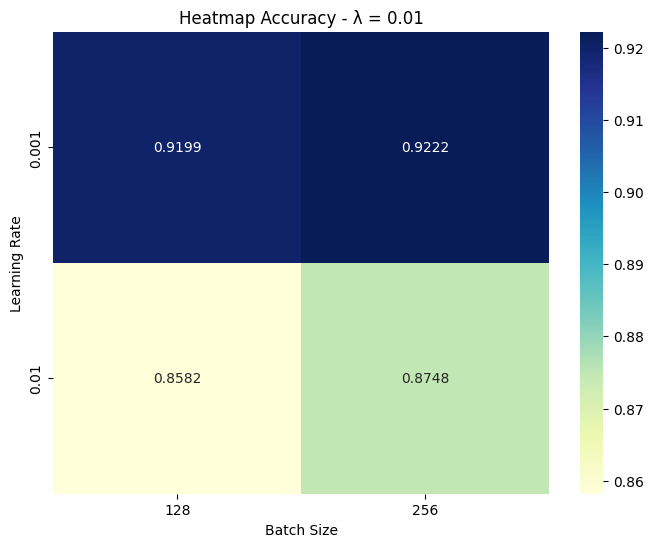

In [11]:
# ----- Définir les hyperparamètres à tester pour model avec optimizer Adam-----
learning_rates = [0.001, 0.01]
batch_sizes    = [128, 256]
lamda_value    = [0.001, 0.01]
n_splits       = 5

# Préparer un tableau 3D : (lr, bs, lamda)
mean_val_accuracy = np.zeros((len(learning_rates), len(batch_sizes), len(lamda_value)))


# ----- Standardisation -----
scaler = StandardScaler()
X_temp = scaler.fit_transform(X_temp)


# ----- Recherche par Cross-Validation -----
for k, lm in enumerate(lamda_value):
    for i, lr in enumerate(learning_rates):
        for j, bs in enumerate(batch_sizes):
            
            print(f"Testing λ={lm}, lr={lr}, batch_size={bs} ...")
            kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
            fold_accuracies = []
    
            for train_index, val_index in kf.split(X_temp):
                
                X_train_fold = X_temp[train_index]
                X_val_fold   = X_temp[val_index]
                y_train_fold = y_temp[train_index]
                y_val_fold   = y_temp[val_index]

                X_train_fold = X_train_fold.reshape(-1, 32, 32)
                X_val_fold   = X_val_fold.reshape(-1, 32, 32)
                
                                
                # Initialiser le modèle
                model = LeNet5(num_classes=33,optimizer='adam',lr=lr,regularisation=lm)
    
                # Entraînement
                _, val_losses, _, val_accs = model.train(
                    X_train_fold, y_train_fold,
                    X_val_fold,   y_val_fold,
                    epochs=50, batch_size=bs
                )
                
                fold_accuracies.append(val_accs[-1])
            
            mean_val_accuracy[i, j, k] = np.mean(fold_accuracies)
            print(f"→ Moyenne CV accuracy λ={lm}, lr={lr}, bs={bs} : {mean_val_accuracy[i, j, k]:.4f}")

# ----- Identifier la meilleure combinaison -----
best_idx = np.unravel_index(np.argmax(mean_val_accuracy), mean_val_accuracy.shape)
best_lr  = learning_rates[best_idx[0]]
best_bs  = batch_sizes[best_idx[1]]
best_lm  = lamda_value[best_idx[2]]
best_acc = mean_val_accuracy[best_idx]

print(f"\nMeilleure combinaison SGD : λ={best_lm}, lr={best_lr}, bs={best_bs} avec CV accuracy={best_acc:.4f}")

# ----- Heatmaps séparées pour chaque λ -----
for k, lm in enumerate(lamda_value):
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        mean_val_accuracy[:, :, k],
        annot=True, fmt=".4f",
        xticklabels=batch_sizes,
        yticklabels=learning_rates,
        cmap="YlGnBu"
    )
    plt.title(f"Heatmap Accuracy - λ = {lm}")
    plt.xlabel("Batch Size")
    plt.ylabel("Learning Rate")
    plt.savefig(f"cv_accuracy_heatmap_lambda_{lm}.png")
    plt.show()



Epoch 0, Train Loss: 0.7863, Val Loss: 0.8720, Train Acc: 0.7578, Val Acc:0.7378
Epoch 10, Train Loss: 0.0973, Val Loss: 0.2330, Train Acc: 0.9766, Val Acc:0.9341
Epoch 20, Train Loss: 0.0540, Val Loss: 0.2152, Train Acc: 0.9844, Val Acc:0.9419
Epoch 30, Train Loss: 0.0342, Val Loss: 0.2139, Train Acc: 0.9844, Val Acc:0.9404
Epoch 40, Train Loss: 0.0234, Val Loss: 0.1999, Train Acc: 1.0000, Val Acc:0.9437
Epoch 50, Train Loss: 0.0324, Val Loss: 0.2041, Train Acc: 0.9922, Val Acc:0.9452
Epoch 60, Train Loss: 0.0370, Val Loss: 0.2147, Train Acc: 1.0000, Val Acc:0.9417
Epoch 70, Train Loss: 0.0111, Val Loss: 0.1784, Train Acc: 1.0000, Val Acc:0.9522
Epoch 80, Train Loss: 0.0326, Val Loss: 0.1784, Train Acc: 0.9844, Val Acc:0.9499
Epoch 90, Train Loss: 0.0163, Val Loss: 0.1757, Train Acc: 1.0000, Val Acc:0.9505

Rapport de classification (Test set) avec la meilleure combinaison :
              precision    recall  f1-score   support

           ⴰ       0.98      1.00      0.99       156
  

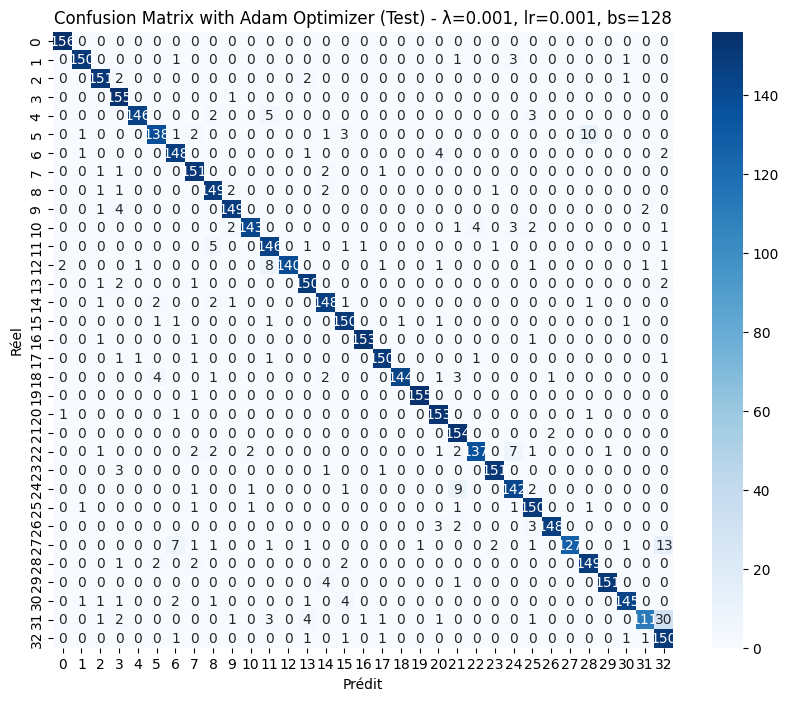

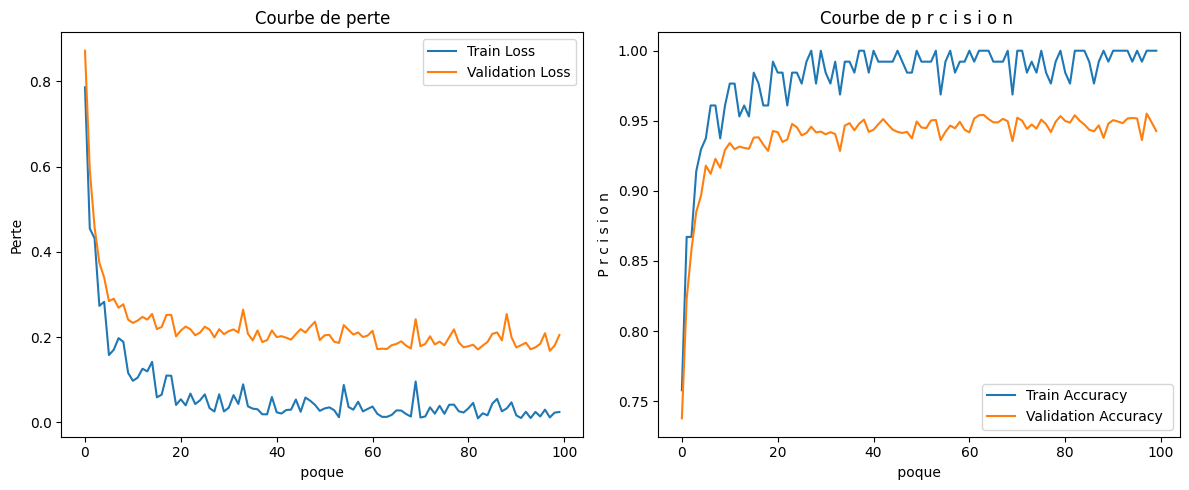

In [12]:
# Avant entraînement
X_train_reshaped = X_train   # (N, 3*32*32)
X_val_reshaped   = X_val
X_test_reshaped  = X_test

# Les labels : si tu utilises l'encodage simple (pas one-hot)
y_train_labels = y_train
y_val_labels   = y_val
y_test_labels  = y_test


# ----- Réentraînement final avec les meilleurs hyperparamètres -----
model = LeNet5(num_classes=33,optimizer='adam',lr=best_lr,regularisation=best_lm)


train_losses, val_losses,train_acc,val_acc = model.train(X_train_reshaped, y_train_labels,
    X_val_reshaped, y_val_labels,
    epochs=100,batch_size=best_bs
)

# ----- Évaluation finale -----
y_test_pred = model.predict(X_test_reshaped)

print("\nRapport de classification (Test set) avec la meilleure combinaison :")
print(classification_report(y_test, y_test_pred, target_names=le.classes_))

cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f"Confusion Matrix with Adam Optimizer (Test) - λ={best_lm}, lr={best_lr}, bs={best_bs}")
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.savefig("confusion_matrix_best.png")
plt.show()

# Courbes de perte et d’accuracy
fig , (ax1 , ax2) = plt.subplots(1, 2, figsize =(12, 5))

# Courbe de perte
ax1.plot(train_losses , label='Train Loss')
ax1.plot(val_losses , label='Validation Loss')
ax1.set_title('Courbe de perte')
ax1.set_xlabel(' poque ')
ax1.set_ylabel('Perte')
ax1.legend ()

# Courbe d’accuracy
ax2.plot(train_acc , label='Train Accuracy ')
ax2.plot(val_acc , label='Validation Accuracy ')
ax2.set_title('Courbe de p r c i s i o n ')
ax2.set_xlabel(' poque ')
ax2.set_ylabel(' P r c i s i o n ')
ax2.legend ()

plt.tight_layout ()
fig.savefig('loss_accuracy_plot.png')
plt.show()
